<a href="https://colab.research.google.com/github/neha-369-tes/neha-369-tes/blob/main/Detecting_emotions_using_EEG_waves_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
birdy654_eeg_brainwave_dataset_feeling_emotions_path = kagglehub.dataset_download('birdy654/eeg-brainwave-dataset-feeling-emotions')

print('Data source import complete.')


Data source import complete.


![](https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2014/04/brainFacts-579411100-770x533-1-745x490.jpg)

Problem in hand : Given EEG data from subjects who were watching movies, let's try to predict the emotional state of a subject during a given movie.

### Importing necessary libraries

In [46]:
!pip install scikeras
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional, BatchNormalization, PReLU, ReLU, Reshape, Conv1D, Conv2D, Add, MaxPool1D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ SciKeras wrapper
from scikeras.wrappers import KerasClassifier


### Reading EEG data with feature extracted

In [47]:
from tensorflow import keras


In [48]:
data = pd.read_csv("/content/emotions.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [49]:
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


### Viewing a sample of time series data

In [50]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']

In [51]:
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


<Axes: >

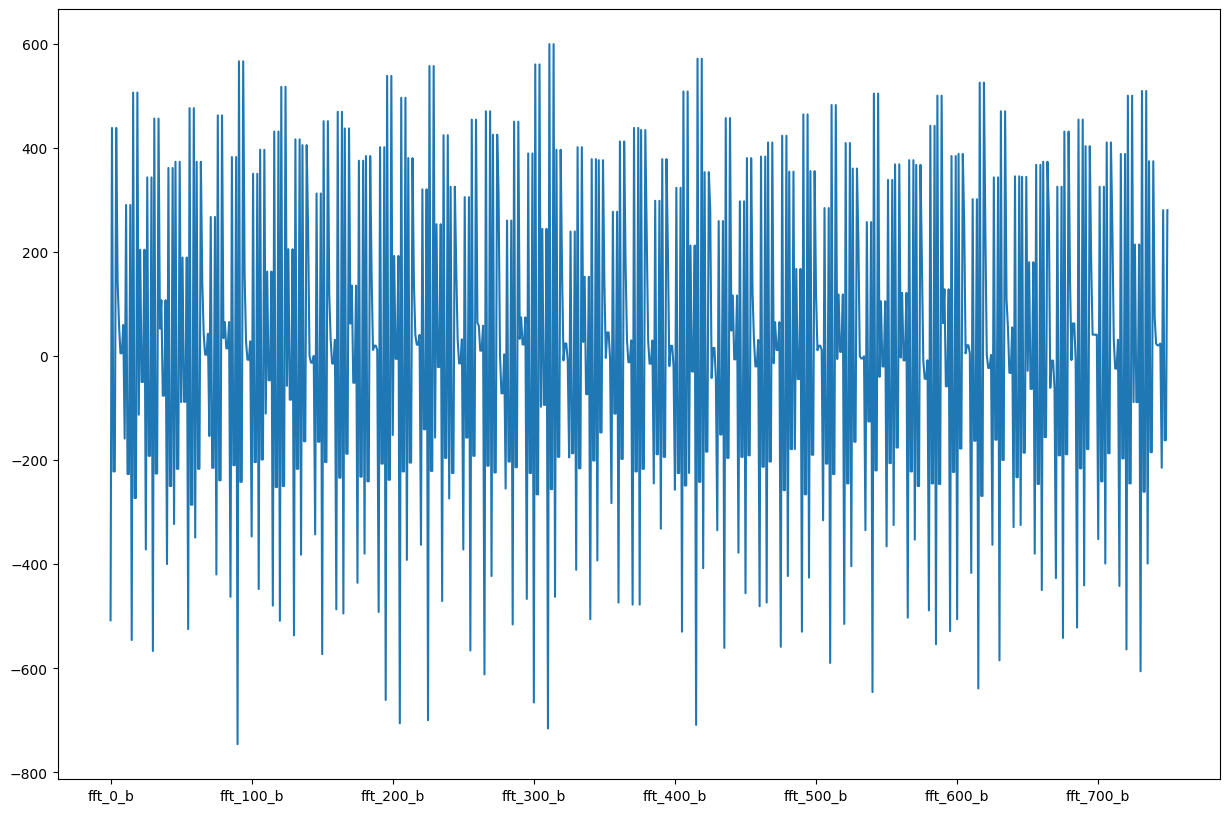

In [52]:
fft_data.iloc[0,:].plot(figsize=(15,10))

### Encoding the 3 distinct labels

The 3 labels are : "NEGATIVE", "NEUTRAL" and "POSITIVE".

In [53]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

### Defining necessary features for model training.

In [54]:
y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Defining the Model's architecture

In [55]:
inputs = tf.keras.Input(shape=(X_train.shape[1],1))

gru = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2548, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 2548, 256)      │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 652288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │     1,956,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,779 (8.22 MB)

 Trainable params: 2,155,779 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

### Plotting the model

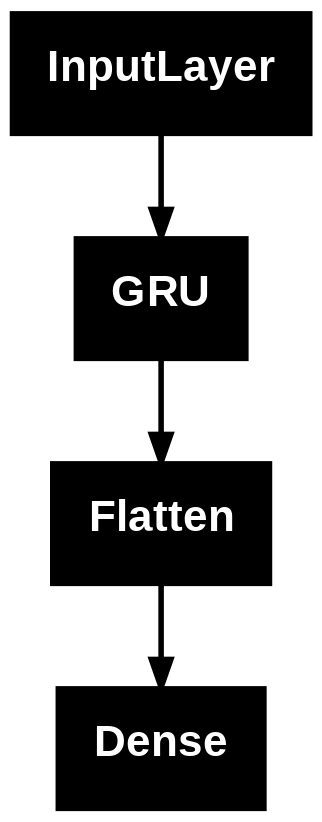

In [56]:
tf.keras.utils.plot_model(model)

### Training the model.

The loss function used will be 'Categorical_CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.

We will be training for 100 epochs starting with learning_rate = 0.001 and batch_size = 64.

In [57]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])

        saved_model = load_model(save_to + '_best_model.h5')

        return model,history

In [58]:
print(x_train.dtype)


NameError: name 'x_train' is not defined

In [ ]:
model,history = train_model(model, X_train, y_train,X_test, y_test, save_to= './', epoch = 40)
print(x_train.dtype)


Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6810 - loss: 44.5761
Epoch 1: val_accuracy improved from -inf to 0.93594, saving model to ./_best_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 469s 10s/step - accuracy: 0.6831 - loss: 44.1819 - val_accuracy: 0.9359 - val_loss: 3.5366 - learning_rate: 0.0010
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9062 - loss: 5.7506
Epoch 2: val_accuracy did not improve from 0.93594
47/47 ━━━━━━━━━━━━━━━━━━━━ 502s 11s/step - accuracy: 0.9061 - loss: 5.7498 - val_accuracy: 0.8984 - val_loss: 14.1920 - learning_rate: 9.0484e-04
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9219 - loss: 4.9946
Epoch 3: val_accuracy improved from 0.93594 to 0.96250, saving model to ./_best_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 453s 10s/step - accuracy: 0.9225 - loss: 4.9574 - val_accuracy: 0.9625 - val_loss: 1.9546 - learning_rate: 8.1873e-04
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9827 - loss: 0.7853
Epoch 4: val_accuracy did not improve from 0.96250
47/47 ━━━━━━━━━━━━━━━━━━━━ 509s 10s/step - accuracy: 0.9826 - loss: 0.7907 - val_accuracy: 0.9438 - val_loss: 2.4757 - learning_rate: 7.4082e-04
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9924 - loss: 0.2168
Epoch 5: val_accuracy improved from 0.96250 to 0.97031, saving model to ./_best_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 521s 10s/step - accuracy: 0.9924 - loss: 0.2156 - val_accuracy: 0.9703 - val_loss: 1.4776 - learning_rate: 6.7032e-04
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9867 - loss: 0.3063
Epoch 6: val_accuracy did not improve from 0.97031
47/47 ━━━━━━━━━━━━━━━━━━━━ 487s 10s/step - accuracy: 0.9866 - loss: 0.3068 - val_accuracy: 0.9688 - val_loss: 2.3789 - learning_rate: 6.0653e-04
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9935 - loss: 0.1903
Epoch 7: val_accuracy improved from 0.97031 to 0.97656, saving model to ./_best_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 512s 11s/step - accuracy: 0.9936 - loss: 0.1883 - val_accuracy: 0.9766 - val_loss: 1.5833 - learning_rate: 5.4881e-04
Epoch 8/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9980 - loss: 0.0409
Epoch 8: val_accuracy did not improve from 0.97656
47/47 ━━━━━━━━━━━━━━━━━━━━ 484s 10s/step - accuracy: 0.9979 - loss: 0.0433 - val_accuracy: 0.9750 - val_loss: 1.2963 - learning_rate: 4.9659e-04
Epoch 9/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9950 - loss: 0.0839
Epoch 9: val_accuracy did not improve from 0.97656
47/47 ━━━━━━━━━━━━━━━━━━━━ 489s 10s/step - accuracy: 0.9950 - loss: 0.0838 - val_accuracy: 0.9766 - val_loss: 1.2037 - learning_rate: 4.4933e-04
Epoch 10/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9997 - loss: 0.0082
Epoch 10: val_accuracy did not improve from 0.97656
47/47 ━━━━━━━━━━━━━━━━━━━━ 481s 10s/step - accuracy: 0.9997 - loss: 0.0084 - val_accuracy: 0.9688 - val_loss: 2.0009 - learning_rate: 4.0657e-04
Epoch 11/40
47/4

47/47 ━━━━━━━━━━━━━━━━━━━━ 479s 10s/step - accuracy: 0.9984 - loss: 0.0031 - val_accuracy: 0.9797 - val_loss: 1.3685 - learning_rate: 3.0119e-04
Epoch 14/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9992 - loss: 0.0067
Epoch 14: val_accuracy did not improve from 0.97969
47/47 ━━━━━━━━━━━━━━━━━━━━ 471s 10s/step - accuracy: 0.9992 - loss: 0.0067 - val_accuracy: 0.9734 - val_loss: 1.2799 - learning_rate: 2.7253e-04
Epoch 15/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 1.0000 - loss: 3.6909e-08
Epoch 15: val_accuracy did not improve from 0.97969
47/47 ━━━━━━━━━━━━━━━━━━━━ 493s 11s/step - accuracy: 1.0000 - loss: 3.7011e-08 - val_accuracy: 0.9719 - val_loss: 1.3189 - learning_rate: 2.4660e-04
Epoch 16/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 1.0000 - loss: 2.0552e-08
Epoch 16: val_accuracy did not improve from 0.97969
47/47 ━━━━━━━━━━━━━━━━━━━━ 491s 10s/step - accuracy: 1.0000 - loss: 2.1605e-08 - val_accuracy: 0.9719 - val_loss: 1.3191 - learning_rate: 2.2313e

### Plotting the validation curves

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating the model

1. Test accuracy

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

2. Confusion matrix along with classification reports (includes metrics like precision, F1-score)

In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## Please upvote if you found it useful :)